# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [88]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, isnull
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder \
   .master("local") \
   .appName("Sparkify Mini") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.first()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
#View in a more readable format
df.select(df.columns).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df.count()

286500

In [8]:
for col in df.columns:
    missing_count = df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()
    print(col + ": " + str(missing_count))

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


In [9]:
df.select('auth').describe().show()

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+



In [10]:
#Look at unque values in the auth column
df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



Users who Cancelled are the ones who churned

In [11]:
df.filter(df.auth == 'Cancelled').select(['gender', 'length', 'level', 'location', 'page', 'userId']).show()

+------+------+-----+--------------------+--------------------+------+
|gender|length|level|            location|                page|userId|
+------+------+-----+--------------------+--------------------+------+
|     M|  null| paid|  Kansas City, MO-KS|Cancellation Conf...|    18|
|     M|  null| paid|Phoenix-Mesa-Scot...|Cancellation Conf...|    32|
|     M|  null| free|  Corpus Christi, TX|Cancellation Conf...|   125|
|     M|  null| paid|Indianapolis-Carm...|Cancellation Conf...|   105|
|     F|  null| paid|Philadelphia-Camd...|Cancellation Conf...|    17|
|     F|  null| free|Virginia Beach-No...|Cancellation Conf...|   143|
|     M|  null| paid|Denver-Aurora-Lak...|Cancellation Conf...|   101|
|     M|  null| paid|           Flint, MI|Cancellation Conf...|   129|
|     M|  null| paid|Oxnard-Thousand O...|Cancellation Conf...|   121|
|     M|  null| paid|Lexington-Fayette...|Cancellation Conf...|    51|
|     M|  null| paid|       Quincy, IL-MO|Cancellation Conf...|    87|
|     

In [12]:
df.filter(df.auth == 'Cancelled').count()

52

In [13]:
df.filter(df.page == 'Cancellation Confirmation').count()

52

In [14]:
#Delete rows with an empty or blank userId
def clean_userid(df):
    df = df.dropna(subset = 'userId')
    df = df.filter(df.userId != '')
    return df
df = clean_userid(df)

In [15]:
df.count()

278154

In [16]:
df.filter(df.auth == 'Cancelled').count()

52

In [17]:
df.filter(df.page == 'Cancellation Confirmation').count()

52

In [18]:
#look at what a churned user did before leaving
user_id = df.filter(df.userId == '32').orderBy('ts')
user_id.count()

108

In [19]:
user_id.select(user_id.columns).toPandas().tail(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,Natiruts,Logged In,Diego,M,8,Mckee,210.88608,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Jamaica Roots II(Agora E Sempre),200,1538580267000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
9,Alan Barratt,Logged In,Diego,M,9,Mckee,652.14649,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Dusk,200,1538580477000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
10,Daughtry,Logged In,Diego,M,10,Mckee,240.22159,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,September,200,1538581129000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
11,Craig David,Logged In,Diego,M,11,Mckee,357.06730,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Slicker Than Your Average,200,1538581369000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
12,Slightly Stoopid,Logged In,Diego,M,12,Mckee,198.53016,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Mellow Mood,200,1538581726000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
13,BeyoncÃÂ©,Logged In,Diego,M,13,Mckee,293.14567,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Dangerously In Love,200,1538581924000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
14,Coldplay,Logged In,Diego,M,14,Mckee,294.11220,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Fix You,200,1538582217000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
15,De Saloon,Logged In,Diego,M,15,Mckee,200.82893,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1537167593000,218,Morder,200,1538582511000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
16,None,Logged In,Diego,M,16,Mckee,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Roll Advert,1537167593000,218,None,200,1538582541000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
17,None,Logged In,Diego,M,17,Mckee,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,Logout,1537167593000,218,None,307,1538582542000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32


In [20]:
#Creating churn column, idea for method taken from https://github.com/Minsifye/Sparkify/blob/master/Sparkify.ipynb
churned_users = [(row['userId']) for row in df.filter(df.page=="Cancellation Confirmation").select('userId').dropDuplicates().collect()]

df = df.withColumn("Churn", df.userId.isin(churned_users))

In [21]:
df.filter(df.Churn == 1).count()

44864

In [22]:
df_pandas = df.toPandas()

In [23]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


# Plotting

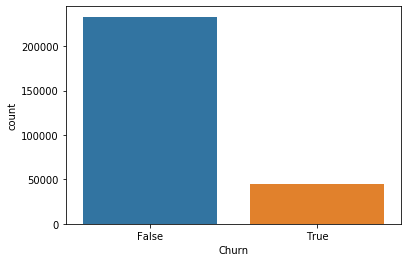

In [24]:
sns.countplot(df_pandas['Churn']) #Visualize how many people churned
plt.show()

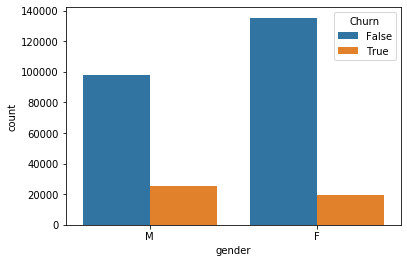

In [25]:
sns.countplot(df_pandas['gender'], hue= df_pandas['Churn'])
plt.show()

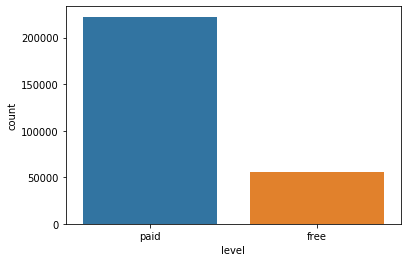

In [26]:
sns.countplot(df_pandas['level'])
plt.show()

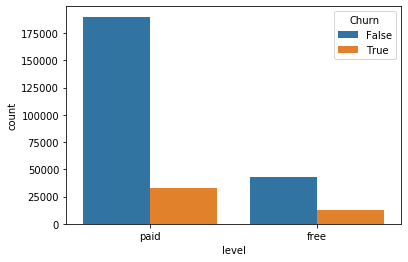

In [27]:
sns.countplot(df_pandas['level'], hue= df_pandas['Churn'])
plt.show()

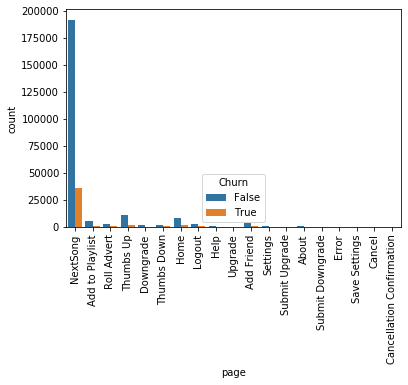

In [28]:
page = sns.countplot(df_pandas['page'], hue = df_pandas['Churn'])
plt.setp(page.get_xticklabels(), rotation=90)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
#Keep relevant columns and transform them to numerical formats
df = df.select(['artist', 'gender', 'length', 'level', 'userId', 'song', 'page', 'Churn'])

In [30]:
df.columns

['artist', 'gender', 'length', 'level', 'userId', 'song', 'page', 'Churn']

In [31]:
df.select(df.columns).toPandas().head()

,artist,gender,length,level,userId,song,page,Churn
0,Martha Tilston,M,277.89016,paid,30,Rockpools,NextSong,False
1,Five Iron Frenzy,M,236.09424,free,9,Canada,NextSong,False
2,Adam Lambert,M,282.82730,paid,30,Time For Miracles,NextSong,False
3,Enigma,M,262.71302,free,9,Knocking On Forbidden Doors,NextSong,False
4,Daft Punk,M,223.60771,paid,30,Harder Better Faster Stronger,NextSong,False


In [32]:
df.describe().show()

+-------+------------------+------+-----------------+------+-----------------+--------------------+-------+
|summary|            artist|gender|           length| level|           userId|                song|   page|
+-------+------------------+------+-----------------+------+-----------------+--------------------+-------+
|  count|            228108|278154|           228108|278154|           278154|              228108| 278154|
|   mean| 551.0852017937219|  null|249.1171819778458|  null|59682.02278593872|            Infinity|   null|
| stddev|1217.7693079161374|  null|99.23517921058361|  null|109091.9499991047|                 NaN|   null|
|    min|               !!!|     F|          0.78322|  free|               10|ÃÂg ÃÂtti Gr...|  About|
|    max| ÃÂlafur Arnalds|     M|       3024.66567|  paid|               99|ÃÂau hafa slopp...|Upgrade|
+-------+------------------+------+-----------------+------+-----------------+--------------------+-------+



In [33]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- page: string (nullable = true)
 |-- Churn: boolean (nullable = true)



Need to work with categorical columns and transform them to numerical

In [34]:
def transform(df):
    #Gender column
    df = df.replace(['M', 'F'], ['0', '1'], 'gender')
    df = df.withColumn('gender', df["gender"].cast(IntegerType()))
    
    #Level column
    df = df.replace(['free', 'paid'], ['0', '1'], 'level')
    df = df.withColumn('level', df['level'].cast(IntegerType()))

    #Churn column
    df = df.withColumn('Churn', df['Churn'].cast(IntegerType()))
    
    return df

df = transform(df)

In [35]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- page: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [36]:
#Taking features that are ready into a seperate dataframe
X = df.groupBy(["userId", "Churn", "gender", "level"]).count()
X.show()

+------+-----+------+-----+-----+
|userId|Churn|gender|level|count|
+------+-----+------+-----+-----+
|    75|    0|     1|    1|  957|
|   114|    0|     0|    1| 1387|
|    65|    0|     0|    0|  148|
|    38|    0|     0|    0|   96|
|     4|    0|     0|    1| 2301|
|200023|    0|     1|    0| 2041|
|   108|    0|     1|    1|  569|
|    80|    0|     1|    0|  474|
|    37|    0|     0|    1| 1603|
|100015|    1|     1|    1|  397|
|300011|    0|     1|    1| 5456|
|    33|    0|     0|    1| 1529|
|    67|    0|     0|    0|  206|
|   147|    0|     0|    0|  205|
|   123|    0|     0|    0|  196|
|100004|    0|     1|    1|  554|
|200022|    0|     0|    0|  456|
|200024|    1|     0|    1|  210|
|    15|    0|     0|    1| 2278|
|    77|    0|     1|    0|   98|
+------+-----+------+-----+-----+
only showing top 20 rows



In [37]:
#Turn each action in the page column into a column, idea taken from https://github.com/Minsifye/Sparkify/blob/master/Sparkify.ipynb
action_list = [row['page'] for row in df.select('page').dropDuplicates().collect()]

In [38]:
action_list

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [39]:
#Remove actions which will not be helpful
actions_remove = ['Cancel', 'Home', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings']
for action in actions_remove:
    action_list.remove(action)

In [40]:
action_list

['Submit Downgrade',
 'Thumbs Down',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [41]:
#Turning each action into a seperate column with counts
for action in action_list:
    df_temp = df.filter(df.page == action).groupBy(df.userId).count()
    df_temp = df_temp.withColumnRenamed('count', action)
    X = X.join(df_temp, 'userId', how='left')

In [42]:
X.select(X.columns).toPandas().head()

,userId,Churn,gender,level,count,Submit Downgrade,Thumbs Down,Downgrade,Roll Advert,Logout,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,100010,0,1,0,381,NaN,5.0,NaN,52.0,5.0,7.0,4.0,275,17.0,2.0,2.0,NaN,NaN
1,200002,0,0,0,120,NaN,6.0,5.0,7.0,5.0,8.0,4.0,387,21.0,2.0,2.0,NaN,1.0
2,200002,0,0,1,354,NaN,6.0,5.0,7.0,5.0,8.0,4.0,387,21.0,2.0,2.0,NaN,1.0
3,125,1,0,0,11,NaN,NaN,NaN,1.0,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN
4,124,0,1,1,4825,NaN,41.0,41.0,4.0,59.0,118.0,74.0,4079,171.0,23.0,NaN,6.0,NaN


In [43]:
for col in X.columns:
    missing_count = X.filter((isnan(X[col])) | (X[col].isNull()) | (X[col] == "")).count()
    print(col + ": " + str(missing_count))

userId: 0
Churn: 0
gender: 0
level: 0
count: 0
Submit Downgrade: 262
Thumbs Down: 23
Downgrade: 79
Roll Advert: 23
Logout: 12
Add to Playlist: 10
Add Friend: 20
NextSong: 0
Thumbs Up: 5
Help: 38
Upgrade: 58
Error: 157
Submit Upgrade: 98


In [44]:
X = X.filter(X.userId.isNotNull())
X = X.na.fill(0)

In [45]:
#Remove columns which will not be fed into the model
columns_to_drop = ['userId', 'count']
X = X.drop(*columns_to_drop)

In [46]:
X.select(X.columns).toPandas().head()

,Churn,gender,level,Submit Downgrade,Thumbs Down,Downgrade,Roll Advert,Logout,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,0,1,0,0,5,0,52,5,7,4,275,17,2,2,0,0
1,0,0,0,0,6,5,7,5,8,4,387,21,2,2,0,1
2,0,0,1,0,6,5,7,5,8,4,387,21,2,2,0,1
3,1,0,0,0,0,0,1,0,0,0,8,0,0,0,0,0
4,0,1,1,0,41,41,4,59,118,74,4079,171,23,0,6,0


In [64]:
print("Total number of rows: " + str(X.count()))
print("Total number of churned rows: " + str(X.filter(X.Churn == 1).count()))

Total number of rows: 360
Total number of churned rows: 82


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
#Turning all feature columns into one column
assembler = VectorAssembler(inputCols = X.columns[1:], outputCol = "features_vector")
data = assembler.transform(X).select('features_vector', 'Churn')

#Standardize the values in the feature column
std_scaler = StandardScaler(inputCol="features_vector", outputCol="features", withStd=True)
scalerModel = std_scaler.fit(data)
final_data = scalerModel.transform(data)

In [48]:
train_data, test_data = final_data.randomSplit([.8, .2])

In [65]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Churn')
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Churn')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Churn')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn')

In [66]:
print("*****Training logistic regression*****")
start_time = time.time()
logistic_model = lr.fit(train_data)
print((time.time() - start_time)/60.0)
print("*****Training decision tree*****")
start_time = time.time()
decision_tree_model = dt.fit(train_data)
print((time.time() - start_time)/60.0)
print("*****Training GBT*****")
start_time = time.time()
gbt_tree_model = gbt.fit(train_data)
print((time.time() - start_time)/60.0)
print("*****Training random forest*****")
start_time = time.time()
random_forest_model = rf.fit(train_data)
print((time.time() - start_time)/60.0)

*****Training logistic regression*****
10.852643382549285
*****Training decision tree*****
5.684787515799204
*****Training GBT*****
19.365799760818483
*****Training random forest*****
7.611255729198456


In [67]:
logistic_predictions = logistic_model.transform(test_data)
decision_tree_predictions = decision_tree_model.transform(test_data)
gbt_predictions = gbt_tree_model.transform(test_data)
random_forest_predictions = random_forest_model.transform(test_data)

In [72]:
accuracy = MulticlassClassificationEvaluator(labelCol = 'Churn', predictionCol = "prediction", metricName = "accuracy")
f1 = MulticlassClassificationEvaluator(labelCol = 'Churn', predictionCol = "prediction", metricName = 'f1')
recall = MulticlassClassificationEvaluator(labelCol = 'Churn', predictionCol = "prediction", metricName = 'weightedRecall')
auc = BinaryClassificationEvaluator(labelCol = 'Churn', metricName = 'areaUnderROC')

In [73]:
logistic_accuracy = accuracy.evaluate(logistic_predictions)
decision_tree_accuracy = accuracy.evaluate(decision_tree_predictions)
gbt_accuracy = accuracy.evaluate(gbt_predictions)
random_forest_accuracy = accuracy.evaluate(random_forest_predictions)

logistic_f1 = f1.evaluate(logistic_predictions)
decision_tree_f1 = f1.evaluate(decision_tree_predictions)
gbt_f1 = f1.evaluate(gbt_predictions)
random_forest_f1 = f1.evaluate(random_forest_predictions)

logistic_recall = recall.evaluate(logistic_predictions)
decision_tree_recall = recall.evaluate(decision_tree_predictions)
gbt_recall = recall.evaluate(gbt_predictions)
random_forest_recall = recall.evaluate(random_forest_predictions)

logistic_auc = auc.evaluate(logistic_predictions)
decision_tree_auc = auc.evaluate(decision_tree_predictions)
gbt_auc = auc.evaluate(gbt_predictions)
random_forest_auc = auc.evaluate(random_forest_predictions)

In [74]:
Accuracy = list([logistic_accuracy, decision_tree_accuracy, gbt_accuracy, random_forest_accuracy])
F1_Score = list([logistic_f1, decision_tree_f1, gbt_f1, random_forest_f1])
Recall = list([logistic_recall, decision_tree_recall, gbt_recall, random_forest_recall])
AUC = list([logistic_auc, decision_tree_auc, gbt_auc, random_forest_auc])

df_evaluation = pd.DataFrame({'Accuracy':Accuracy, 'F1_Score':F1_Score, 'Recall': Recall, 'Area Under Curve': AUC})

df_evaluation.index = ['Logistic Regression', 'Decision Tree', 'Gradient Boosted Tree', 'Random Forest']
df_evaluation

,Accuracy,F1_Score,Recall,Area Under Curve
Logistic Regression,0.743590,0.691142,0.743590,0.713889
Decision Tree,0.871795,0.869075,0.871795,0.537963
Gradient Boosted Tree,0.935897,0.932010,0.935897,0.952778
Random Forest,0.769231,0.690498,0.769231,0.813889


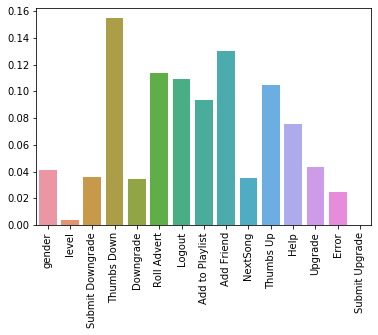

In [87]:
# plot feature importances for gradient boosting
importances = gbt_tree_model.featureImportances.toArray()
features = X.columns[1:]
feature_importance = sns.barplot(x = features, y = importances)
plt.setp(feature_importance.get_xticklabels(), rotation=90)
plt.show()

# Hyperparameter tuning on Gradient Boosted Trees

In [92]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [117]:
evaluator = MulticlassClassificationEvaluator(labelCol='Churn')
param_grid = ParamGridBuilder().addGrid(gbt.maxBins, [35, 40]).addGrid(gbt.maxDepth, [2,4,6,8]).addGrid(gbt.maxIter, [30]).build()
cv = CrossValidator(estimator = gbt, evaluator = evaluator, estimatorParamMaps = param_grid, numFolds = 5)

In [118]:
best_model = cv.fit(train_data)

In [119]:
tuning_predictions = best_model.transform(test_data)

tuning_accuracy = accuracy.evaluate(tuning_predictions)
tuning_f1 = f1.evaluate(tuning_predictions)
tuning_recall = recall.evaluate(tuning_predictions)
tuning_auc = auc.evaluate(tuning_predictions)

In [120]:
tuning_df_evaluation = pd.Series({'Accuracy':tuning_accuracy, 'F1_Score':tuning_f1, 'Recall': tuning_recall, 'Area Under Curve': tuning_auc})

tuning_df_evaluation

Accuracy            0.910256
F1_Score            0.911092
Recall              0.910256
Area Under Curve    0.901852
dtype: float64